#Mount Drive And Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load library
!pip install -q wordcloud-fa
!pip install -q gensim
#import library
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
import re
import gensim
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from keras.layers import Dropout,Embedding,GlobalMaxPool1D,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from wordcloud_fa import WordCloudFa
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.5.0


#Load Dataset

In [ ]:
# # df = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/7-offDSA2020-dev-train-test-10000.xlsx')
# # df.head()
# # df.describe

# df_train = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/train.xlsx')
# df_valid = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/dev.xlsx')
# df_test = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/test.xlsx')

In [ ]:
#load dataset
df_train = pd.read_excel("/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/train.xlsx")
df_valid = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/dev.xlsx')
df_test_tweets = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/test.xlsx')
df_test_labels = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/offLabel.xlsx')

#Rename Columns
df_train = df_train.rename(columns={'off': 'OFF_Labels','hs': 'HS_Labels'})
df_valid = df_valid.rename(columns={'off': 'OFF_Labels','hs': 'HS_Labels'})
df_test_labels=df_test_labels.rename(columns={'labels':'OFF_Labels'})

df_test=pd.concat([df_test_tweets, df_test_labels], axis=1)

#drop any row have null values
df_train=df_train.dropna(how='any',axis=0)
df_valid=df_valid.dropna(how='any',axis=0)
# df_train.drop(columns=['HS_Labels'])
# df_valid.drop(columns=['HS_Labels'])
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)


(6983, 2)
(1000, 3)
(2000, 2)


In [ ]:
# df = df.drop(['hs','new_label'], axis=1)

Text(0.5, 1.0, 'Hate speech Data Distribution')

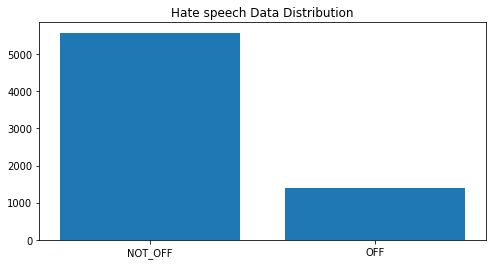

In [ ]:
val_count = df_train.OFF_Labels.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Hate speech Data Distribution")

In [ ]:
import random
random_idx_list = [random.randint(1,len(df_train.tweets)) for i in range(10)] # creates random indexes to choose from dataframe
df_train.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,tweets,OFF_Labels
3674,صبّ ضحكاتك يصبّ المزن أواه يا ضعفي و يا غلبي أ...,NOT_OFF
4687,يا حسرتي يا وجودي يا كسر قلبي و عودي URL,NOT_OFF
3839,@USER تسلمي يا ذوق يا بنت الأصول يا متربية 😂,NOT_OFF
2956,رجولك عسل يا قلبي .. يا ليت اصير دلاغك — يع URL,NOT_OFF
4257,RT @USER: انهض يا مانشستر<LF>لا تيأس يا يونايت...,NOT_OFF
6339,كانت ايام يا وطني زي الاحلام يا وطني,NOT_OFF
6849,ما هذا الفكر يا فوساتي يا عبقري لعنة الله عليك...,OFF
2667,@USER @USER @USER وليه يا شداد يا شلة اللقيمات...,NOT_OFF
1418,ما الحل يا مشكلة يا مدللة ما الحل❤️,NOT_OFF
6388,@USER يا حبيبتي يا مصر يا مصر ♥️,NOT_OFF


#Text Preprocessing¶


In [ ]:
text_cleaning_re = "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]|[.#،<>@,\\-_”“٪ًَ]"
def preprocess(text):
  #remove tashkeel
  p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(p_tashkeel,"", str(text))
  # text = text.replace('وو', 'و')
  # text = text.replace('يي', 'ي')
  # text = text.replace('اا', 'ا')
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  #remove longation
  text = re.sub(r'(.)\1+', r'\1\1', str(text)) 
  text = re.sub("[إأآا]", "ا", str(text))
  text = re.sub("ى", "ي", str(text))
  # text = re.sub("ؤ", "ء", text)
  # text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", str(text))
  # for i in range(0, len(search)):
  #       text = text.replace(search[i], replace[i])
  
   #trim    
  # text = text.strip()

  tokens = []
  for token in text.split():
    # if token not in stop_words:
      tokens.append(token)
  return " ".join(tokens)

In [ ]:
# preprocess('مشكوووور hello 156562سٌلمُ@#')
preprocess('_ salam # @  حمقى 12 ممتازة ياااااااارب ؟ ! سٌلمُ')

'حمقي ممتازه ياارب ؟ ! سلم'

In [ ]:
df_train.tweets = df_train.tweets.apply(lambda x: preprocess(x))
df_valid.tweets = df_valid.tweets.apply(lambda x: preprocess(x))
df_test.tweets = df_test.tweets.apply(lambda x: preprocess(x))
# df.tweets[:10]

#Data Presentation

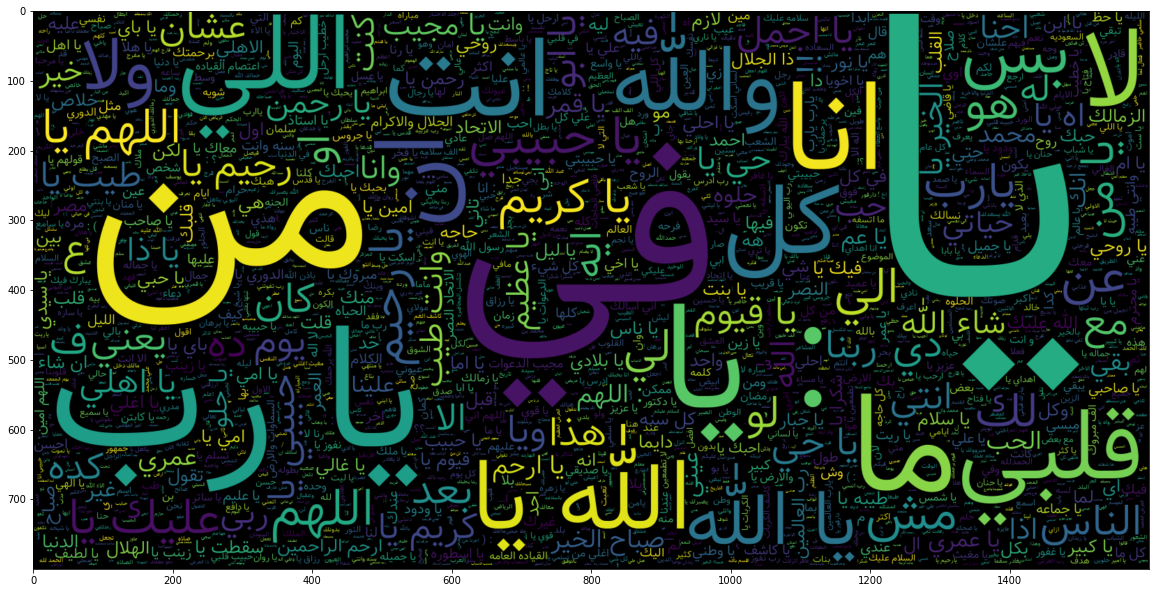

In [ ]:
#Not Offensive Words
plt.figure(figsize = (20,20)) 
wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_train[df_train.OFF_Labels == 'NOT_OFF'].tweets))
image = wc.to_image()
image.save('wordcloud.png')
plt.imshow(wc , interpolation = 'bilinear')

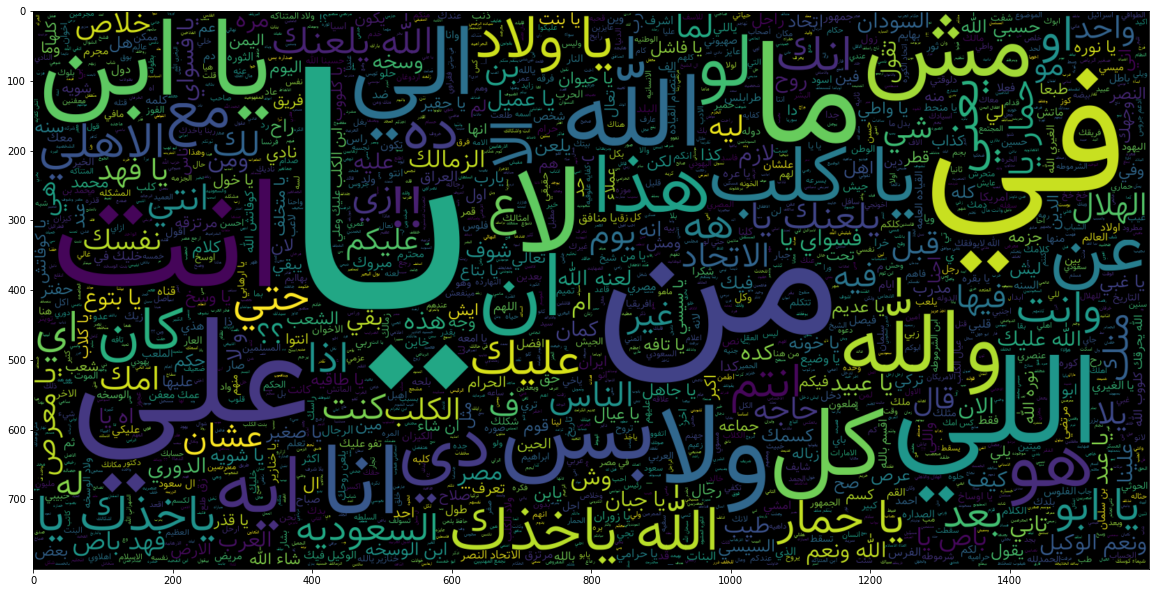

In [ ]:
plt.figure(figsize = (20,20)) 
wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_train[df_train.OFF_Labels=='OFF'].tweets))
image = wc.to_image()
image.save('wordcloudoff.png')
plt.imshow(wc , interpolation = 'bilinear')

# Train and Test Split

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 30

In [ ]:
# train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
#                                          random_state=7) # Splits Dataset into Training and Testing set
# print("Train Data size:", len(train_data))
# print("Test Data size", len(test_data))
# X_train, X_test, y_train, y_test = train_test_split(df.tweets,df.off, test_size = 0.2, random_state = 42, stratify=df.off)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = 42, stratify=y_train)

# print("Train Data size:", len(X_train))
# print("Test Data size", len(X_test))
# print("Val Data size", len(X_val))

In [ ]:
# train_data.head(10)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweets)
# tokenizer.fit_on_texts(X_test)
tokenizer.fit_on_texts(df_valid.tweets)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 35193


In [ ]:

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.tweets),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(tokenizer.texts_to_sequences(df_valid.tweets),
                       maxlen = MAX_SEQUENCE_LENGTH)

X_test=pad_sequences(tokenizer.texts_to_sequences(df_test.tweets),maxlen=MAX_SEQUENCE_LENGTH)
print("Training X Shape:",X_train.shape)
print("Validation X Shape:",X_val.shape)
print("Testing X Shape:",X_test.shape)


Training X Shape: (6983, 30)
Validation X Shape: (1000, 30)
Testing X Shape: (2000, 30)


In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.OFF_Labels.to_list())
# encoder.fit(y_val.to_list())
# encoder.fit(y_test.to_list())

y_train = encoder.transform(df_train.OFF_Labels.to_list())
y_val = encoder.transform(df_valid.OFF_Labels.to_list())
Y_test = encoder.transform(df_test.OFF_Labels.to_list())

y_train = y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", Y_test.shape)
print("y_val shape:", y_val.shape)


y_train shape: (6983, 1)
y_test shape: (2000, 1)
y_val shape: (1000, 1)


# Word embedding

In [ ]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 30
# load the model
modelwv = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/Word Embedding/Twt-CBOW/Twt-CBOW')

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in modelwv.wv.vocab:
      embedding_vector = modelwv[word]
    else:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
print(embedding_matrix.shape)
# EMBEDDING_DIM=300


(35193, 300)


In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model Training - LSTM


In [ ]:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=7,),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False)),
    LSTM(128, return_sequences=True),
    # tf.keras.layers.Conv1D(filters=64, kernel_size=5,),
    # tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1)
])



In [ ]:
# Adam(learning_rate=LR)
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
# ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
#                                      min_lr = 0.01,
#                                      monitor = 'val_loss',
#                                      verbose = 1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
]

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_val, y_val), callbacks=my_callbacks)

Epoch 1/30
7/7 [==============================] - 5s 190ms/step - loss: 1.0013 - accuracy: 0.7559 - val_loss: 0.5603 - val_accuracy: 0.8210
Epoch 2/30
7/7 [==============================] - 0s 43ms/step - loss: 0.5263 - accuracy: 0.7974 - val_loss: 0.4808 - val_accuracy: 0.8087
Epoch 3/30
7/7 [==============================] - 0s 39ms/step - loss: 0.5042 - accuracy: 0.7895 - val_loss: 0.4719 - val_accuracy: 0.8154
Epoch 4/30
7/7 [==============================] - 0s 40ms/step - loss: 0.4960 - accuracy: 0.7970 - val_loss: 0.4612 - val_accuracy: 0.8212
Epoch 5/30
7/7 [==============================] - 0s 40ms/step - loss: 0.4882 - accuracy: 0.7993 - val_loss: 0.4627 - val_accuracy: 0.8231
Epoch 6/30
7/7 [==============================] - 0s 40ms/step - loss: 0.4829 - accuracy: 0.8005 - val_loss: 0.4572 - val_accuracy: 0.8224
Epoch 7/30
7/7 [==============================] - 0s 39ms/step - loss: 0.4772 - accuracy: 0.8000 - val_loss: 0.4586 - val_accuracy: 0.8222
Epoch 8/30
7/7 [==========

In [ ]:
scores = model.evaluate(X_train,y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print(y_train)

accuracy: 83.13%


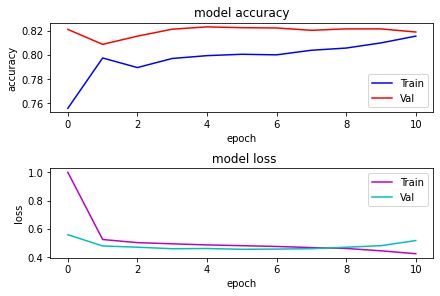

In [ ]:
s, (at, al) = plt.subplots(2,1,constrained_layout=True)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Train', 'Val'], loc='lower right')
# at.scatter(x, y)
# at.legend_
al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title(' model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['Train', 'Val'], loc = 'upper right')

In [ ]:
# evaluate the model
scorestest = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scorestest[1]*100))

accuracy: 79.69%


In [ ]:
model.evaluate(X_test, Y_test)

63/63 [==============================] - 0s 5ms/step - loss: 0.5465 - accuracy: 0.7969


[0.5464639067649841, 0.7968750596046448]

#Confusion Matrix¶


In [ ]:
def decode_sentiment(score):
    return "OFF" if (score>0.5).any() else "NOT_OFF"

scores = model.predict(X_test, verbose=1, batch_size=100)

scores.astype(np.float32)
type(scores)
y_pred_1d = np.array([decode_sentiment(score) for score in scores])
print(y_pred_1d[:10])
print(Y_test[:10])

20/20 [==============================] - 1s 5ms/step
['NOT_OFF' 'OFF' 'NOT_OFF' 'NOT_OFF' 'NOT_OFF' 'NOT_OFF' 'NOT_OFF'
 'NOT_OFF' 'NOT_OFF' 'NOT_OFF']
[[1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [ ]:
pred_new = []
for i in y_pred_1d:
  # print(i)
  if i == 'OFF':
    pred_new.append(1)
  else:
    pred_new.append(0)
print(pred_new)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(classification_report(list(Y_test), pred_new))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1598
           1       0.48      0.03      0.06       402

    accuracy                           0.80      2000
   macro avg       0.64      0.51      0.48      2000
weighted avg       0.74      0.80      0.72      2000



In [ ]:
# word = preprocess(u'حقير')
# model = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/WE/Twt-CBOW/Twt-CBOW')
# # find and print the most similar terms to a word
# most_similar = model.wv.most_similar( word )
# for term, score in most_similar:
# 	print(term, score)
 
# word_vector = model.wv[ word ]